# 2. Deep Learning

Las deep network, o lo que hoy en día se conoce como deep learning, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).

Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes feed forward, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?

En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el backpropagation hacia las primeras capas de la red.

>a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de pruebas.

Se volverá a trabajar con el dataset Boston Housing. El problema consiste en predecir el precio de una casa en una zona/barrio de Boston (USA) a partir de una serie de atributos que describen el lugar que éste se ubica. Debido a que en la pregunta se explicó el contenido de sus datos, no se realizará en esta oportunidad.

Se realiza el mismo tratamiento a los datos, donde la variable CHAS se convertirá en dos columnas CHAS_0 y CHAS_1. Además, se normalizarán los datos para evitar problemas númericos que se pudiesen generar por la diferencia de rangos de las variables, y que tan dispersas pudiesen estar.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import pandas as pd
from sklearn.cross_validation import train_test_split

url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical

df_train,df_test = train_test_split(df,test_size=0.25, random_state=0)

In [44]:
# Normalización de los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_train.columns)

y_train = X_train_scaled.pop('MEDV').values.reshape([-1,1])
y_test = X_test_scaled.pop('MEDV').values.reshape([-1,1])

i_dim = X_train_scaled.shape[1]

>b) Para el mismo problema definido anteriormente (sección 1) se entrenará diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (loss) para el conjunto de entrenamiento respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de gradients (link) en el backend de Keras. Deberá generar un histograma para todos los pesos de cada capa antes y despues del entrenamiento con 300 epochs. Comente.

En esta sección se trabajará con la red neuronal simple de una capa con 200 neuronas y función de activación sigmoidal, expuesta en la pregunta 1.b). Se inicializan los pesos con una uniforme. Se estudiará el comportamiento del gradiente de la función de pérdida para el conjunto de entrenamiento y testing respecto a los pesos en las distintas capas.

Primero se importan las librerías necesarias para trabajar con redes neuronales, además de otras para graficar los histogramas de los pesos de las capas.

In [45]:
import tensorflow as tf
import keras
from keras import backend as K
import matplotlib.pyplot as plt
#plt.style.use('seaborn-pastel')
%matplotlib inline
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import seaborn as sns
sns.set(color_codes=True)

Se define la red, calculando los gradientes. En evaluated_gradients se encontrán los gradientes en los índices pares y los bias en los impares.

In [46]:
model = Sequential()
model.add(Dense(200, input_dim=i_dim, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

###calculate gradients
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
#We can now calculate the gradients.
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

w_first_layer = evaluated_gradients[0].flatten()
w_second_layer = evaluated_gradients[2].flatten()

Se entrena el modelo, por lo que se espera a que los pesos de la red cambie.

In [47]:
hist_b = model.fit(X_train_scaled, y_train, epochs=300, verbose=0, validation_data=(X_test_scaled, y_test))
###calculate gradients
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
#We can now calculate the gradients.
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

w_after_fl = evaluated_gradients[0].flatten()
w_after_sl = evaluated_gradients[2].flatten()

Teniendo el conjunto de pesos para la primera y segunda capa para ambos estados de la red, se procede a gráficos los histogramas separando en "previo entrenamiento" y "pos entrenamiento".

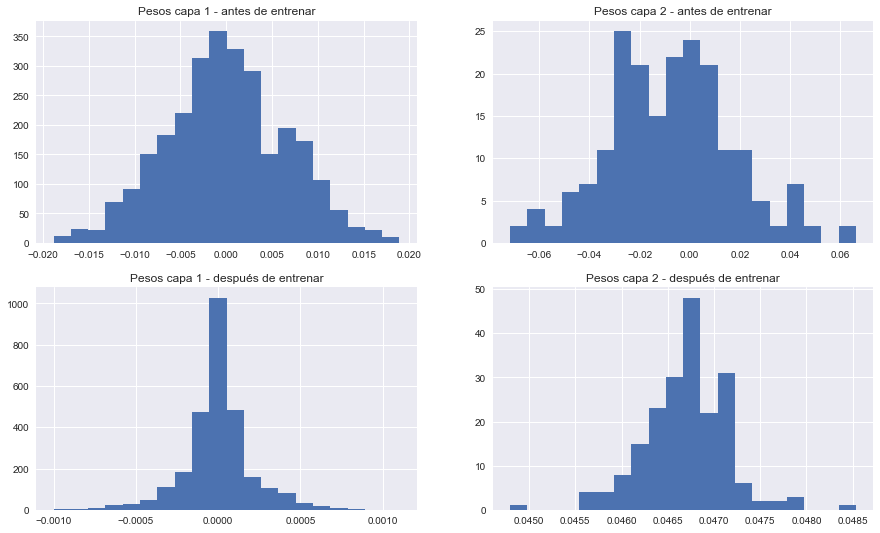

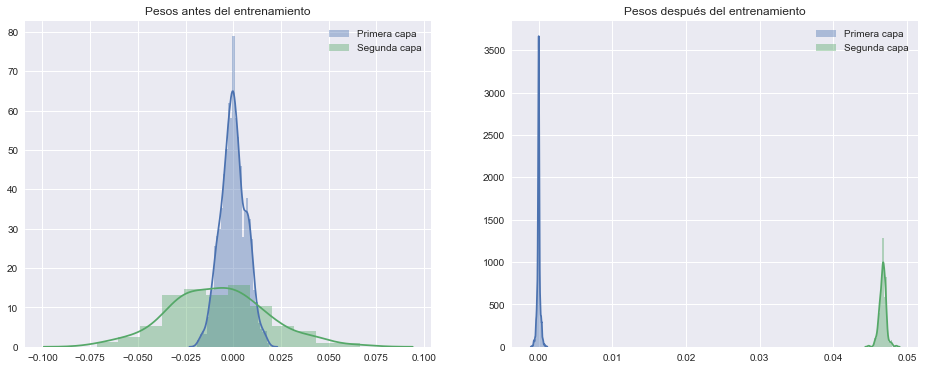

In [48]:
plt.figure(figsize=(15,9))
plt.subplot(221)
plt.hist(w_first_layer,20)
plt.title("Pesos capa 1 - antes de entrenar")

plt.subplot(222)
plt.hist(w_second_layer,20)
plt.title("Pesos capa 2 - antes de entrenar")

plt.subplot(223)
plt.hist(w_after_fl,20)
plt.title("Pesos capa 1 - después de entrenar")

plt.subplot(224)
plt.hist(w_after_sl,20)
plt.title("Pesos capa 2 - después de entrenar")
plt.show()

#
plt.figure(figsize=(16,6))
plt.subplot(121)
#plt.hist(w_first_layer,20)
sns.distplot(w_first_layer, label='Primera capa');
sns.distplot(w_second_layer, label='Segunda capa');
plt.title('Pesos antes del entrenamiento')
plt.legend() 

plt.subplot(122)
sns.distplot(w_after_fl, label='Primera capa');
sns.distplot(w_after_sl, label='Segunda capa');
plt.title('Pesos después del entrenamiento')
plt.legend() 
plt.show()

El primer histograma para la capa uno revela que hay cierta simetría de los valores de los pesos centrados en 0. Esto se debe a que fueron inicializados de forma uniforme y tienden a concentrarse en los valores medios del rango de evaluación. Luego del entrenamiento siguen estándo centrados en cero, pero aumenta la cantidad (casi al doble) los que tienen valores cercanos a cero.

Los valores de la capa de salida pasan a ser de valores negativos, en su mayoría, a positivos. Esto tiene sentido pues al trabajar con valores de precios de casas, estos viven en los reales positivos, por lo que los atributos suman al precio final más que restar.

En la segunda ronda de gráficos se visualiza la comparación entre los histogramas de las capas. Como se mencionó antes los pesos de la capa de salida pasan del lado de los reales negativos a los reales positivos. Además, ambos histogramas se adelgazan acumulando más datos en su centro. Para la primera se produce esto pues la alta cantidad de neuronas induce a que los pesos sean menores.

>c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho mas profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos uniform el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visual visualice las 3-4 primeras capas de la red. Comente si observa el efecto del gradiente desvaneciente antes y/o después de entrenar.

En esta sección se cambiará la arquitectura a una red de 6 capas, 5 de ellas ocultas, y una de salida. En este caso al ser más de 3 capas ocultas se dice que la red es profunda. En otro caso, como la red anterior, se habla de redes *shallow* o poco profundas. Los pesos de la red se setean con un inicializador uniform, el cual escoge valores de una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Esta red utiliza SGD como optimizador con un learning rate = 0.01. El objetivo es analizar el comportamiento de los gradientes mientras más capas tiene una red. 

Se definend dos funciones, usando el mismo procedimiento de b) para el cálculo de los gradientes, así se podrán graficar. 

In [49]:
def network(kernel_init, activation_):
    model = Sequential()
    model.add(Dense(200, input_dim=i_dim, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(1, kernel_initializer=kernel_init,activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

def w_before_train(model):   
    ###calculate gradients
    loss = keras.losses.mean_squared_error(model.output,y_train)
    listOfVariableTensors = model.trainable_weights
    #We can now calculate the gradients.
    gradients = K.gradients(loss, listOfVariableTensors)
    sess = K.get_session()
    evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
    evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
    first = evaluated_gradients[0].flatten()
    second = evaluated_gradients[2].flatten()
    third = evaluated_gradients[4].flatten()
    return first, second, third

def w_after_fit(model):
    model.fit(X_train_scaled, y_train, epochs=300, verbose=0, validation_data=(X_test_scaled, y_test))
    ###calculate gradients
    loss = keras.losses.mean_squared_error(model.output,y_train)
    listOfVariableTensors = model.trainable_weights
    #We can now calculate the gradients.
    gradients = K.gradients(loss, listOfVariableTensors)
    sess = K.get_session()
    evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
    evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
    
    first = evaluated_gradients[0].flatten()
    second = evaluated_gradients[2].flatten()
    third = evaluated_gradients[4].flatten()
    return first, second, third

Se define la función plot_all_hist para mostrar los estados de los gradientes antes y después del entrenamiento. Así, no se repetirá el mismo código en todas las secciones

In [50]:
def plot_all_hist(b1,b2,b3,a1,a2,a3):
    plt.figure(figsize=(17,12))
    plt.subplot(321)
    plt.hist(b1,20)
    plt.title("Pesos capa 1 - antes de entrenar")
    
    plt.subplot(322)
    plt.hist(a1,20)
    plt.title("Pesos capa 1 - después de entrenar")
    
    plt.subplot(323)
    plt.hist(b2,20)
    plt.title("Pesos capa 2 - antes de entrenar")
    
    plt.subplot(324)
    plt.hist(a2,20)
    plt.title("Pesos capa 2 - después de entrenar")
    
    plt.subplot(325)
    plt.hist(b3,20)
    plt.title("Pesos capa 3 - antes de entrenar")

    plt.subplot(326)
    plt.hist(a3,20)
    plt.title("Pesos capa 3 - después de entrenar")
    plt.show()
    #
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    sns.distplot(b1, label='Primera capa', hist=False);
    sns.distplot(b2, label='Segunda capa', hist=False);
    sns.distplot(b3, label='Tercera capa', hist=False);
    plt.title('Pesos antes del entrenamiento')
    plt.legend() 

    plt.subplot(122)
    sns.distplot(a1, label='Primera capa', hist=False);
    sns.distplot(a2, label='Segunda capa', hist=False);
    sns.distplot(a3, label='Segunda capa', hist=False);
    plt.title('Pesos después del entrenamiento')
    plt.legend() 
    plt.show()

Habiendo seteado el marco de trabajo, se entrena una red con inicialización uniform y función de activación sigmoidal. En el siguiente paso se gráfican los gradientes.

In [55]:
uni_sigm = network('uniform', 'sigmoid')
m6_bt_fl, m6_bt_sl, m6_bt_tl = w_before_train(uni_sigm)
m6_at_fl, m6_at_sl, m6_at_tl = w_after_fit(uni_sigm)

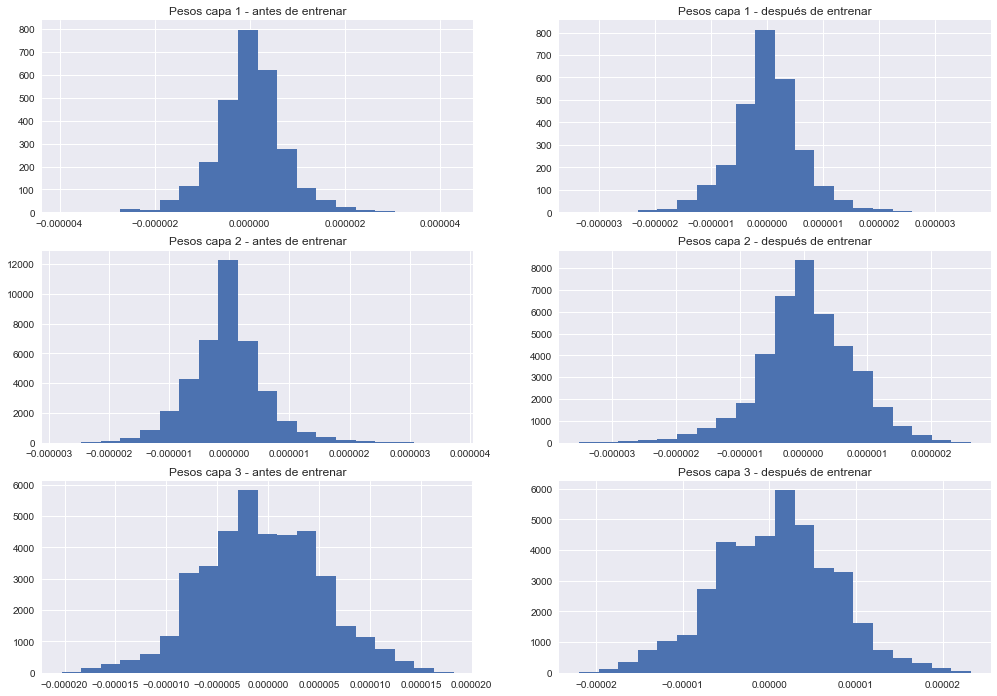

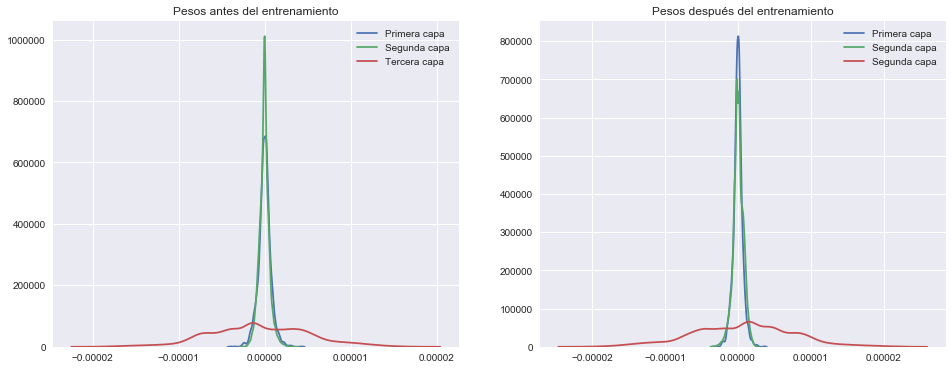

In [56]:
plot_all_hist(m6_bt_fl,m6_bt_sl,m6_bt_tl,m6_at_fl,m6_at_sl,m6_at_tl)

El uso de la iniciación uniform para esta red no afecta en el desvanecimiento de los gradientes pues siempre el valor de N es 200, generando el mismo rango para que la distribución uniforme genere los datos. Lo único que varía es la cantidad de pesos pues en la primera capa hay 14x200 y en las siguientes 200x200. Luego del entrenamiento, las tres capas sufren una disminución de los valores de los pesos pero, por ejemplo en la capa dos hay una redistribución lo que hace que queden más equilibrados y no tan cargados al 0. Los pesos de la capa dos se ven desplazados ligeramente a los valores positivos.

d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [1], es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$ y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del gradiente desvaneciente se amortigua antes y/o después de entrenar.

In [28]:
glorot_sigm = network('glorot_uniform', 'sigmoid')
g_bt_fl, g_bt_sl, g_bt_tl = w_before_train(glorot_sigm)
g_at_fl, g_at_sl, g_at_tl = w_after_fit(glorot_sigm)

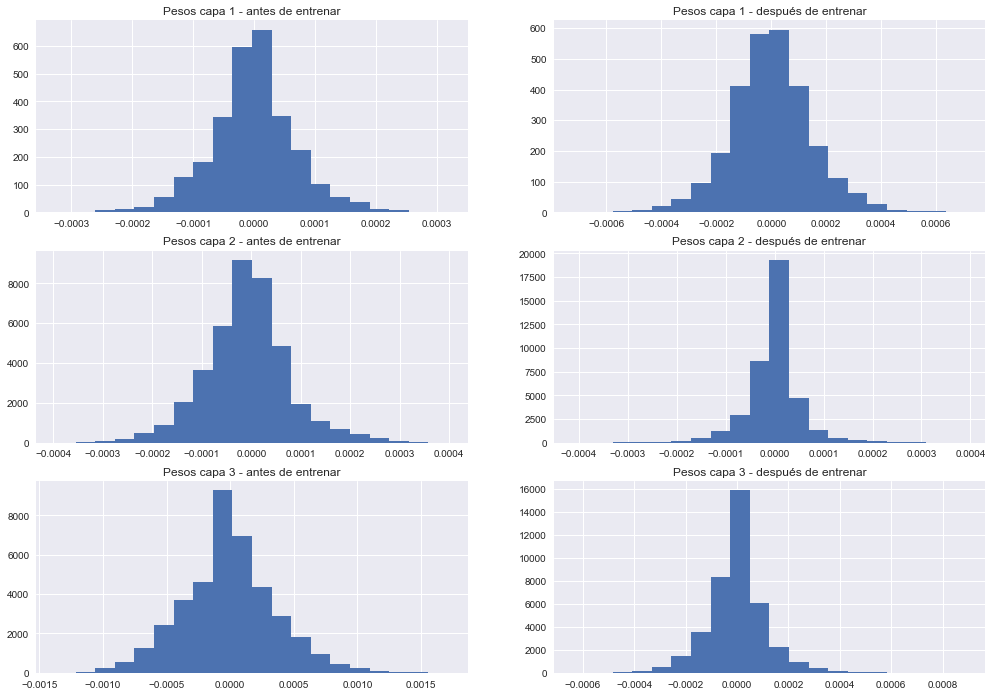

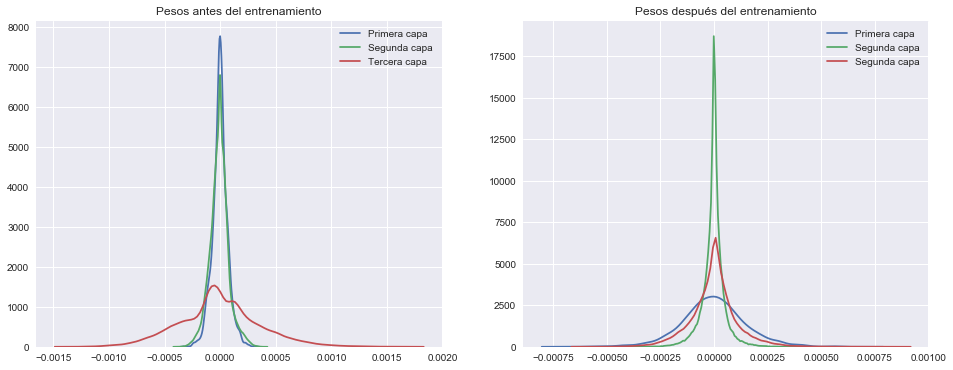

In [29]:
plot_all_hist(g_bt_fl, g_bt_sl, g_bt_tl, g_at_fl, g_at_sl, g_at_tl)

e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización uniform y comparar con la inicialización de He [2], es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del gradiente desvaneciente para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.

In [30]:
uni_relu = network('uniform', 'relu')
ur_bt_fl, ur_bt_sl, ur_bt_tl = w_before_train(uni_relu)
ur_at_fl, ur_at_sl, ur_at_tl = w_after_fit(uni_relu)

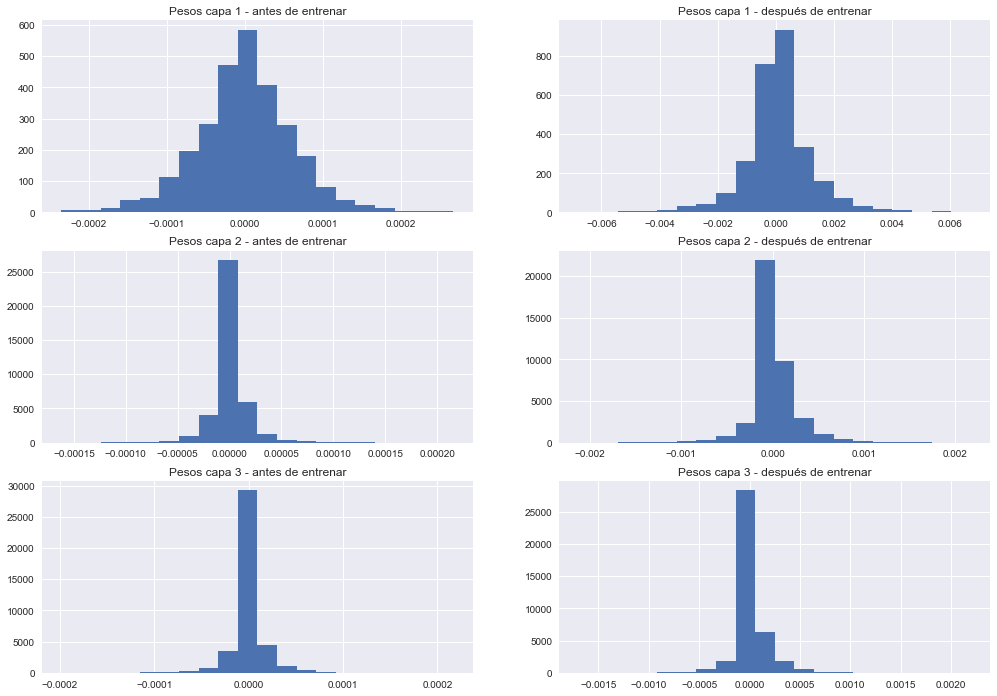

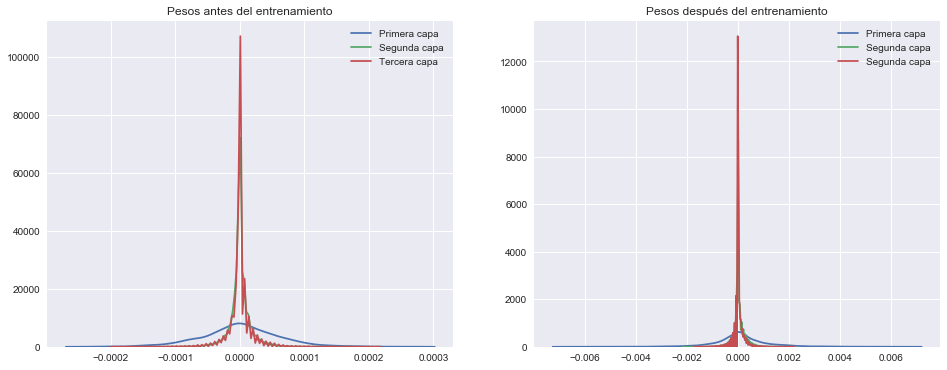

In [31]:
plot_all_hist(ur_bt_fl, ur_bt_sl, ur_bt_tl, ur_at_fl, ur_at_sl, ur_at_tl)

In [32]:
he_uni_relu = network('he_uniform', 'relu')
hur_bt_fl, hur_bt_sl, hur_bt_tl = w_before_train(he_uni_relu)
hur_at_fl, hur_at_sl, hur_at_tl = w_after_fit(he_uni_relu)

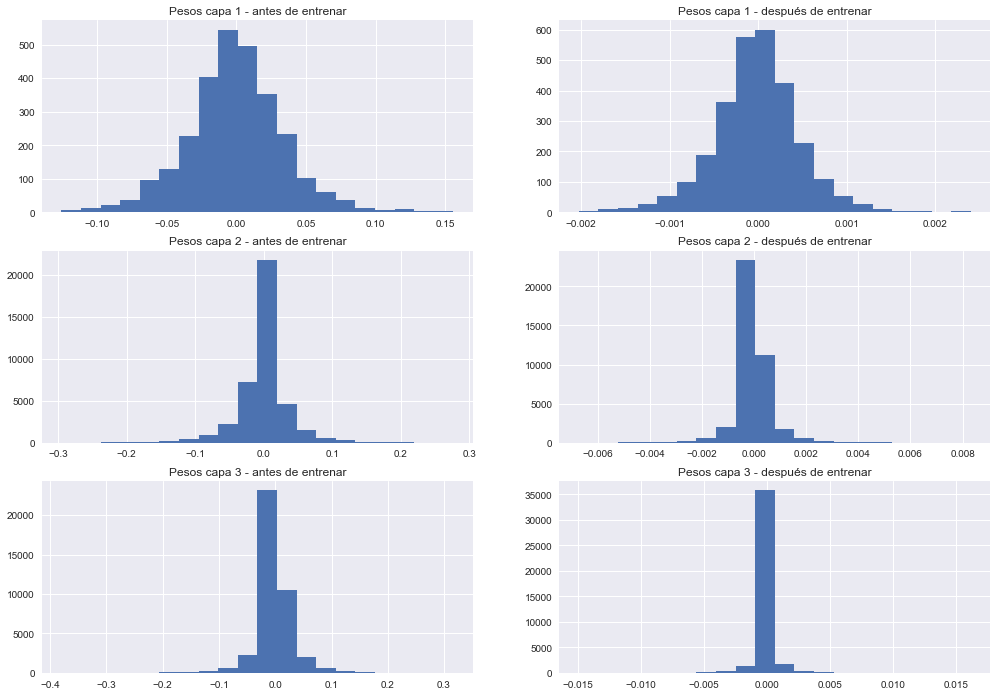

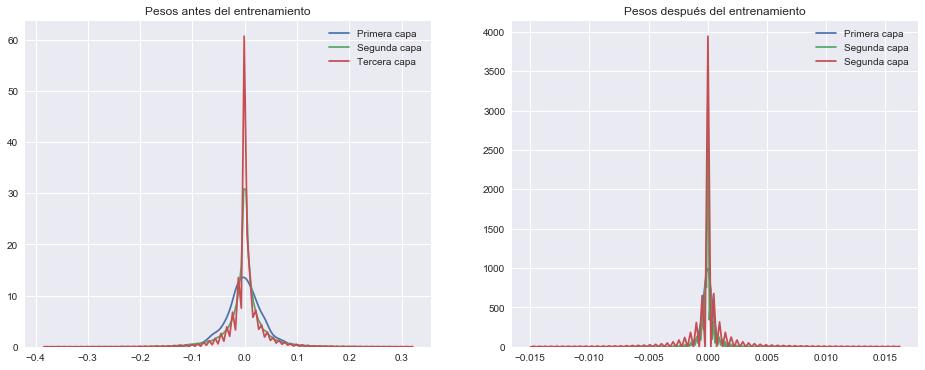

In [33]:
plot_all_hist(hur_bt_fl, hur_bt_sl, hur_bt_tl, hur_at_fl, hur_at_sl, hur_at_tl)

>e) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, momentum, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (mse) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

Para responder a las preguntas, primero debemos visualizar el comportamiento del error cuadrático medio para el modelo generado en b).

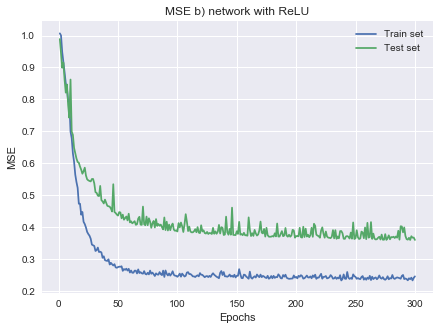

In [57]:
plt.figure(figsize=(7,5))
plt.plot(range(1,301), hist_b.history['loss'])
plt.plot(range(1,301), hist_b.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train set', 'Test set'])
plt.title('MSE b) network with ReLU')
plt.show()

Como se utiliza el mismo modelo que en la pregunta 1, es conocido el comportamiento de rápido descenso del MSE mientras aumentan los epochs, llegando así a una convergencia aproximada a los 50 epochs. También, ya fue analizado el fenómeno de la varianza al tener pics en que sube el error generando una curva que no es suave como las entregadas por los modelos con función de activación ReLU.

Ahora, se vuelve definir la arquitectura de 6 capas y se buscará un modelo de que tenga un error similar o menor al presentado anteriormente, , cambiando el learning rate, la función de activación y el inicializador del kernel.

In [128]:
def network2(kernel_init, activation_,learn_rate):
    model = Sequential()
    model.add(Dense(200, input_dim=i_dim, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200,  kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(200, kernel_initializer=kernel_init,activation=activation_))
    model.add(Dense(1, kernel_initializer=kernel_init,activation='linear'))
    sgd = SGD(lr=learn_rate)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

Se define un modelo (1) con función con las siguientes características:
- Función de activación: ReLU
- Inicializador de kernel: Glorot uniform
- Learning rate: 0.01

Además, se definirá (2) que mantiene las mismas funciones y tasa de aprendizaje que el modelo en b):
- Función de activación: Sigmoidal
- Inicializador de kernel: Uniform
- Learning rate: 0.01

In [160]:
model_deep = network2('glorot_uniform', 'relu', 0.01)
hist_deep = model_deep.fit(X_train_scaled, y_train, epochs=300, verbose=0, 
                           validation_data=(X_test_scaled, y_test))

In [163]:
model_sig = network2('uniform', 'sigmoid', 0.01)
hist_sig = model_sig.fit(X_train_scaled, y_train, epochs=300, verbose=0, 
                         validation_data=(X_test_scaled, y_test))

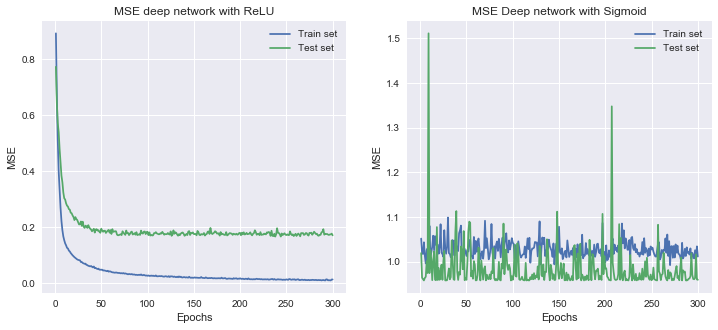

In [161]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(1,301), hist_deep.history['loss'])
plt.plot(range(1,301), hist_deep.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train set', 'Test set'])
plt.title('MSE deep network with ReLU')

plt.subplot(122)
plt.plot(range(1,301), hist_sig.history['loss'])
plt.plot(range(1,301), hist_sig.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train set', 'Test set'])
plt.title('MSE Deep network with Sigmoid')
plt.show()

Sin cambiar el la tasa de aprendizaje la red profunda (1) se obtienen mejores resultados que la red no profunda, tanto para los casos en que se utilizó la combinación Uniforme/Sigmoidal como la función Uniforme/ReLU. Por lo tanto, La inicialización de Glorot mejora por lejos el entrenamiento de la red, llegando en la misma cantidad (aprox.) de epochs a un mejor resultado, con un error de prueba bajo 0.2 y un error de entrenamiento cercano a cero. Prácticamente se reduce a la mitad el error de prueba del modelo en b) y se baja a casi cero el de entrenamiento.

En el caso de la red entrenada con inicialización uniforme y función de activación sigmoidal, los errores son muy altos, oscilando en torno a 1.0, tanto para el entrenamiento como para las pruebas. En este caso la red no es capaz de aprender de los datos de entrada, y por consecuencia, no logra poder predecir datos nuevos que lleguen en un futuro. Por lo tanto, no es recomendado utilizar como activación la función sigmoidal en redes profundas.

- ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento?

Se puede decir que el modelo profundo si logra convergencia en el entrenamiento, y como se puede ver en el gráfico de la arquitectura (A) se ajusta bien a los datos de entrenamiento. Esta convergencia se genera con una alta velocidad y a los pocos epochs. Por lo tanto una red de estas carásteristicas podría ser entrenada con menos iteración sin perder poder de generalizar. Lo que serían interesante realizar a futuro es mejorar las condiciones de entrenamiento para reducir la brecha entre las curvas de entrenamiento y test, pues existe una diferencia no menor entre estas de aprox. 0.15, lo que expresa que la red no generaliza tan bien para los datos futuros.

>f) Pruebe con utilizar una red shallow (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?

Se experimentará con dos redes, una con función de activación Relu y otra Sigmoidal, con el fin de comparar los resultados. La primera será la red con 1000 neuronas en su capa oculta y función de activación ReLU. Se entrena y luego se grafican sus resultados.

In [119]:
model = Sequential()
model.add(Dense(1000, input_dim=i_dim, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_shallow = model.fit(X_train_scaled, y_train, epochs=300,
    verbose=1, validation_data=(X_test_scaled, y_test))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 1s 2ms/step - loss: 0.7647 - val_loss: 0.6754
Epoch 2/300
379/379 [==============================] - 0s 73us/step - loss: 0.5076 - val_loss: 0.5867
Epoch 3/300
379/379 [==============================] - 0s 92us/step - loss: 0.4004 - val_loss: 0.5371
Epoch 4/300
379/379 [==============================] - 0s 69us/step - loss: 0.3382 - val_loss: 0.4952
Epoch 5/300
379/379 [==============================] - 0s 87us/step - loss: 0.2935 - val_loss: 0.4628
Epoch 6/300
379/379 [==============================] - 0s 85us/step - loss: 0.2620 - val_loss: 0.4365
Epoch 7/300
379/379 [==============================] - 0s 89us/step - loss: 0.2373 - val_loss: 0.4085
Epoch 8/300
379/379 [==============================] - 0s 82us/step - loss: 0.2195 - val_loss: 0.3875
Epoch 9/300
379/379 [==============================] - 0s 83us/step - loss: 0.2053 - val_loss: 0.3713
Epoch 10/300
379/379 [===============

379/379 [==============================] - 0s 80us/step - loss: 0.0936 - val_loss: 0.2341
Epoch 81/300
379/379 [==============================] - 0s 90us/step - loss: 0.0936 - val_loss: 0.2345
Epoch 82/300
379/379 [==============================] - 0s 82us/step - loss: 0.0931 - val_loss: 0.2290
Epoch 83/300
379/379 [==============================] - 0s 78us/step - loss: 0.0920 - val_loss: 0.2312
Epoch 84/300
379/379 [==============================] - 0s 70us/step - loss: 0.0920 - val_loss: 0.2323
Epoch 85/300
379/379 [==============================] - 0s 85us/step - loss: 0.0923 - val_loss: 0.2271
Epoch 86/300
379/379 [==============================] - 0s 65us/step - loss: 0.0905 - val_loss: 0.2285
Epoch 87/300
379/379 [==============================] - 0s 79us/step - loss: 0.0912 - val_loss: 0.2275
Epoch 88/300
379/379 [==============================] - 0s 78us/step - loss: 0.0908 - val_loss: 0.2274
Epoch 89/300
379/379 [==============================] - 0s 72us/step - loss: 0.0899 - 

379/379 [==============================] - 0s 88us/step - loss: 0.0701 - val_loss: 0.2066
Epoch 160/300
379/379 [==============================] - 0s 83us/step - loss: 0.0698 - val_loss: 0.2076
Epoch 161/300
379/379 [==============================] - 0s 98us/step - loss: 0.0697 - val_loss: 0.2030
Epoch 162/300
379/379 [==============================] - 0s 71us/step - loss: 0.0694 - val_loss: 0.2036
Epoch 163/300
379/379 [==============================] - 0s 76us/step - loss: 0.0695 - val_loss: 0.2042
Epoch 164/300
379/379 [==============================] - 0s 71us/step - loss: 0.0692 - val_loss: 0.2047
Epoch 165/300
379/379 [==============================] - 0s 71us/step - loss: 0.0689 - val_loss: 0.2064
Epoch 166/300
379/379 [==============================] - 0s 72us/step - loss: 0.0687 - val_loss: 0.2060
Epoch 167/300
379/379 [==============================] - 0s 70us/step - loss: 0.0687 - val_loss: 0.2050
Epoch 168/300
379/379 [==============================] - 0s 79us/step - loss: 

Epoch 238/300
379/379 [==============================] - 0s 86us/step - loss: 0.0573 - val_loss: 0.1921
Epoch 239/300
379/379 [==============================] - 0s 82us/step - loss: 0.0568 - val_loss: 0.1928
Epoch 240/300
379/379 [==============================] - 0s 89us/step - loss: 0.0566 - val_loss: 0.1927
Epoch 241/300
379/379 [==============================] - 0s 88us/step - loss: 0.0567 - val_loss: 0.1937
Epoch 242/300
379/379 [==============================] - 0s 90us/step - loss: 0.0563 - val_loss: 0.1929
Epoch 243/300
379/379 [==============================] - 0s 90us/step - loss: 0.0561 - val_loss: 0.1921
Epoch 244/300
379/379 [==============================] - 0s 87us/step - loss: 0.0560 - val_loss: 0.1948
Epoch 245/300
379/379 [==============================] - 0s 81us/step - loss: 0.0560 - val_loss: 0.1906
Epoch 246/300
379/379 [==============================] - 0s 102us/step - loss: 0.0560 - val_loss: 0.1939
Epoch 247/300
379/379 [==============================] - 0s 102

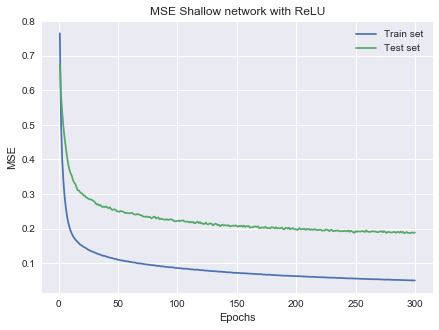

In [121]:
plt.figure(figsize=(7,5))
plt.plot(range(1,301), hist_shallow.history['loss'])
plt.plot(range(1,301), hist_shallow.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train set', 'Test set'])
plt.title('MSE Shallow network with ReLU')
plt.show()

Para esta arquitectura, se mantiene el comportamiento de redes anteriores que decaen con gran velocidad hasta alcanzar un punto de convergencia de 0.18 y 0.5 para las pruebas y entrenamiento respectivamente. No se produce divergencia. Al ocupar 1000 neuronas con ReLU sería parecido a hacer una gran combinación lineal, o función lineal, de los datos de entrada para generar el output. Es por esto que los resultados son buenos, pudiendo el modelo recuperar las características importantes de los datos. Al ocupar más neuronas en la capa se pueden aprender más características de los datos de entrenamiento para predecir datos futuros. El problema es que, a pesar de lo descrito anteriormente, el error de prueba sigue siendo alto. Por lo tanto hay un sobreajuste a los datos de entrenamiento.

Siguiendo con el experimento, se probará con una red confunción de activación sigmoidal.

In [123]:
model = Sequential()
model.add(Dense(1000, input_dim=i_dim, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
hist_shallow = model.fit(X_train_scaled, y_train, epochs=5,
    verbose=1, validation_data=(X_test_scaled, y_test))

Train on 379 samples, validate on 127 samples
Epoch 1/5
379/379 [==============================] - 1s 2ms/step - loss: 155728998568.8748 - val_loss: 25760468972648.8203
Epoch 2/5
379/379 [==============================] - 0s 84us/step - loss: 6498048353237967197700096.0000 - val_loss: 1253205978451970619376402432.0000
Epoch 3/5
379/379 [==============================] - 0s 88us/step - loss: inf - val_loss: inf         
Epoch 4/5
379/379 [==============================] - 0s 79us/step - loss: nan - val_loss: nan
Epoch 5/5
379/379 [==============================] - 0s 82us/step - loss: nan - val_loss: nan


La función sigmoidal no funciona en este tipo de arquitectura pues no logra capturar las características importantes de los datos de entrada. Los resultados arrojan un desempeño paupérrimo divergiendo al en los primeros epochs. Por lo tanto, la arquitectura puede tener buenos como malos resultados dependiendo de las funciones e hiper-parámetros utilizados.

Tener múltiples capas hace que la red sea capaz de reconocer ciertos aspectos de los datos de entrada. Así, ciertas capas se especializarán en reconocer patrones específicos en los datos. Con esto no será necesario tener tantas neuronas por capa pues la carga de trabajo estará distribuida a través de las capas.

En el caso de una red con una capa, ésta podrá aprender de la misma forma las características importantes de un conjunto de entrenamiento, sin embargo, requerirá más neuronas para esta tarea. Por lo tanto, hay un trade-off en el entrenamiento de redes en seleccionar la cantidad de capas a ocupar y como se distribuirán las neuronas en estas capas de trabajo. Es más fácil entrenar redes con pocas capas pero estas pueden generalizar poco, y es más costoso entrenar redes muy profundas pero estarán más especializadas y generalizarán mejor. No olvidar que las selecciones de construcción de cada arquitectura también tienen impacto en el resultado, pues como se mencionó anteriormente, una red de una capa con función sigmoidal tuvo buenos resultados en comparación a la red con función sigmoidal que divergió al comienzo del entrenamiento.